In [3]:
import numpy as np
import copy
from scipy.linalg import eigh
from scipy.sparse.linalg import expm, expm_multiply
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)

In [4]:
# pauli matrices
pauli = np.array([np.array([[1,0],[0,1]]), np.array([[0,1],[1,0]]), np.array([[0,-1.j],[1.j,0]]), np.array([[1,0],[0,-1]])])
pauli_tensor = np.array([[np.kron(pauli[i], pauli[j]) for i in range(4)] for j in range(4)])

# building operators 
def kronecker_pad(matrix, num_qubits, starting_site): 
    ''' pads a 1- or 2- local operator with identities on other sites to get 2^n by 2^n matrix '''
    kron_list = [np.eye(2) for i in range(num_qubits)]    
    kron_list[starting_site] = matrix
    if matrix.shape[0] == 4: 
        del kron_list[starting_site+1]
    
    padded_matrix = kron_list[0]
    for i in range(1, len(kron_list)):
        padded_matrix = np.kron(kron_list[i], padded_matrix)    
    return padded_matrix

# models
def heisenberg(num_qubits, bias_coeff=1.0, x_hopping_coeff=1.0, y_hopping_coeff=1.0, z_hopping_coeff=1.0): 
    terms = []
    for i in range(num_qubits): 
        bias = bias_coeff*kronecker_pad(pauli[3], num_qubits, i)
        terms.append(bias)
        
    for i in range(num_qubits-1): 
        z_hop = z_hopping_coeff*kronecker_pad(pauli_tensor[(3,3)], num_qubits, i)
        terms.append(z_hop)
        y_hop = y_hopping_coeff*kronecker_pad(pauli_tensor[(2,2)], num_qubits, i)
        terms.append(y_hop)
        x_hop = x_hopping_coeff*kronecker_pad(pauli_tensor[(1,1)], num_qubits, i)
        terms.append(x_hop)
    
    return sum(terms)

# used for initial guesses
def basis_state(num_qubits, i): 
    state = np.zeros(2**num_qubits)
    state[i] = 1.0 
    return state

In [53]:
def correction_state(ham, energy, state, tau=0.0001):
    #op = expm(-tau*(ham-energy))
    #correction_state = op @ state
    correction_state = ham @ state - energy*state
    return correction_state / np.linalg.norm(correction_state)

def eff_ham(ham, basis_set): 
    eff_H = np.eye(len(basis_set), dtype=complex)
    for i in range(len(basis_set)): 
        for j in range(len(basis_set)): 
            eff_H[i][j] = basis_set[i].conj().T @ ham @ basis_set[j]
    return eff_H    

def eff_overlap(basis_set): 
    eff_S = np.eye(len(basis_set), dtype=complex)
    for i in range(len(basis_set)): 
        for j in range(len(basis_set)): 
            eff_S[i][j] = basis_set[i].conj().T @ basis_set[j]
    return eff_S
    
def qdavidson_iter(ham, basis_set, tol=0.5):
    num_basis = len(basis_set)
    eff_H = eff_ham(ham, basis_set)
    eff_S = eff_overlap(basis_set)        
    evals, evecs = eigh(eff_H, eff_S)
    estates = [np.array(sum([evecs[:,i][j] * basis_set[j] for j in range(num_basis)])) for i in range(num_basis)]
    new_basis_set = copy.deepcopy(basis_set)
    residue_vals = []
    for i in range(num_basis): 
        print('in')
        val = np.linalg.norm((ham @ estates[i]) - (evals[i] * estates[i]))
        residue_vals.append(val)
        if val > tol: 
            state = correction_state(ham, evals[i], estates[i])            
            if linear_independence(state, new_basis_set, eff_S, tol): 
                print("----addded----")
                '''
                eff_S = np.pad(eff_S, ((0, 1), (0, 1)), mode='constant')
                for i in range(len(new_basis_set)):
                    overlap = state.conj().T @ new_basis_set[i]
                    eff_S[i][len(new_basis_set)] = overlap
                    eff_S[len(new_basis_set)][i] = overlap
                '''
                new_basis_set.append(state)
                eff_S = eff_overlap(new_basis_set)
                eff_H = eff_ham(ham, new_basis_set)
            
    return evals, estates, residue_vals, new_basis_set, eff_H, eff_S

def linear_independence(correction_vec, basis_set, eff_S, tol=0.01): 
    b = np.array([correction_vec.conj().T @ basis_set[i] for i in range(len(basis_set))])
    return np.linalg.norm(np.linalg.pinv(eff_S) @ b) < tol    

def qdavidson(ham, initial_basis_set, num_iter, tol=0.5): 
    basis_set = copy.deepcopy(initial_basis_set)
    for i in range(num_iter): 
        print(f'iter #{i+1}')
        evals, estates, residue_vals, basis_set, eff_H, eff_S = qdavidson_iter(ham, basis_set, tol)
    return evals, estates, residue_vals, basis_set, eff_H, eff_S

In [88]:
num_qubits = 4
ham = heisenberg(num_qubits)
evals, evecs = np.linalg.eigh(ham)
print(evals)

[-6.464 -5.828 -3.828 -3.    -1.828 -1.    -1.    -0.172  0.464  1.
  1.     1.828  3.     3.828  5.     7.   ]


In [103]:
# basis_set = [basis_state(num_qubits, i) for i in range(3)]
c = list("0101") 
UnitVector = lambda c: np.eye(2**num_qubits)[c]
init = UnitVector(int(''.join(c), 2))

basis_set = [init]
evals, estates, residue_vals, basis_set, eff_H, eff_S = qdavidson(ham, basis_set, 4, tol=0.0001)
evals

iter #1
in
----addded----
iter #2
in
----addded----
in
iter #3
in
----addded----
in
in
iter #4
in
----addded----
in
in
in


array([-6.462, -3.82 ,  1.325,  2.958])

In [104]:
def eff_ham_new(ham, basis_set): 
    eff_H = np.eye(len(basis_set), dtype=complex)
    for i in range(len(basis_set)): 
        for j in range(i,len(basis_set)): 
            overlap = basis_set[i].conj().T.dot(ham.dot(basis_set[j]))
            eff_H[i][j] = overlap
            if (i != j):
                eff_H[j][i] = overlap
    return eff_H   

print(eff_ham_new(ham, basis_set))
print()
print(eff_ham(ham, basis_set))

[[-3.   +0.j  3.464+0.j  0.   +0.j  0.   +0.j  0.   +0.j]
 [ 3.464+0.j -0.333+0.j  2.494+0.j  0.   +0.j -0.   +0.j]
 [ 0.   +0.j  2.494+0.j -3.667+0.j -1.852+0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j -1.852+0.j  1.   +0.j -0.756+0.j]
 [ 0.   +0.j -0.   +0.j  0.   +0.j -0.756+0.j  1.   +0.j]]

[[-3.   +0.j  3.464+0.j  0.   +0.j  0.   +0.j  0.   +0.j]
 [ 3.464+0.j -0.333+0.j  2.494+0.j  0.   +0.j -0.   +0.j]
 [ 0.   +0.j  2.494+0.j -3.667+0.j -1.852+0.j  0.   +0.j]
 [-0.   +0.j  0.   +0.j -1.852+0.j  1.   +0.j -0.756+0.j]
 [ 0.   +0.j -0.   +0.j  0.   +0.j -0.756+0.j  1.   +0.j]]


In [105]:
tf = 10
ts = np.linspace(0, tf, 200)

# init = basis_set[1]
# init = np.array([0,1,0])

c0 = np.zeros(len(basis_set))
c0[0] = 1

def QKFFEvolve(t, init):
    ct = expm(-1j * t * np.linalg.inv(eff_S) @ eff_H) @ init
    return sum([ct[i] * basis_set[i] for i in range(len(ct))])

exact_te = [expm_multiply(-1j * ham * t, init) for t in ts]
qkff_te = [QKFFEvolve(t, c0) for t in ts]

In [106]:
print(len(basis_set))
exact_final_te = expm_multiply(-1j * ham * ts[-1], init)
qkff_final_te = QKFFEvolve(ts[-1], c0)
print(np.abs(np.conj(exact_final_te) @ qkff_final_te)**2)

5
0.9999999999999294


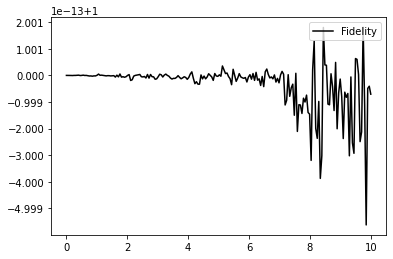

In [107]:
# O = np.kron(np.kron(np.kron(I,I),Z), np.kron(I,I))
# O = np.kron(Z,I)
# O = np.kron(Z, np.kron(I,I))

fidelity = [np.abs(np.conj(psi) @ phi)**2 for psi,phi in zip(exact_te, qkff_te)]

# exact_Z1 = [(np.conj(psi) @ O @ psi).real for psi in exact_te]
# qkff_Z1 = [(np.conj(psi) @ O @ psi).real for psi in qkff_te]

exact_auto = [(np.conj(init) @ psi).real for psi in exact_te]
qkff_auto = [(np.conj(init) @ psi).real for psi in qkff_te]


# plt.plot(ts, exact_Z1, label="Theoretical")
# plt.plot(ts, qkff_Z1, "r--", label="QKFF")
plt.plot(ts, fidelity, 'k', label="Fidelity")

# plt.plot(ts, exact_auto, label="Exact auto")
# plt.plot(ts, qkff_auto, "r--", label="QDFF auto")

# plt.plot(ts, qkff_Z1, 'r--', label="QKFF, R=1, M=6")
plt.legend(loc='upper right')

In [121]:
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.eye(2)

O = np.kron(np.kron(I, Z), np.kron(Z, I))

exact_final_te = expm_multiply(-1j * ham * ts[-1], init)
qkff_final_te = QKFFEvolve(ts[-1], c0)
ct = expm(-1j * ts[-1] * np.linalg.inv(eff_S) @ eff_H) @ c0

print(np.conj(qkff_final_te) @ O @ qkff_final_te)

obs = []
for psi in basis_set:
    obs.append(np.conj(psi) @ O @ psi)

print(sum([(ct[i].real * obs[i]) + (ct[i].imag * obs[i]) for i in range(len(ct))]))

(-0.9773574569957088+0j)
(-0.787757423349683+0j)


In [110]:
np.linalg.norm(ct)

0.9999999999999999